# Train your first computer vision model
### How to use data augmentation and convolutional neural networks to train a face recognition system

In this tutorial you work with images taken from the participants beforehand with our WhoRU webapp.


At the end of the tutorial you can save your model, which later can then be plugged into our WhoRU webapp to check how good it performs as compared to the other uploads.

Have fun!

Particular parameters you should play with are highlighted by a comment #

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import os
import glob
#from face_detection import get_face, convert_to_face_only
from  sklearn.model_selection import train_test_split
from shutil import copyfile
# Keras stuff
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,Reshape
import pickle
from face_detection import convert_to_face_only

## Set some important parameters

In [51]:
DATA_PATH = "./img/" #where are the images located
MODEL_FILENAME= 'try_run_people_model.h5' #where to store the Keras model (including weights)
# Image dimensions for cropped pictures
FINAL_HEIGHT=120
FINAL_WIDTH=120
AUGMENT_VALIDATION = True

## Get an overview of the available  data

In [9]:
classes = [ name for name in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, name)) ]
nclasses = len(classes)
files = {cl:glob.glob(DATA_PATH+cl+"/*.jpg") for cl in classes}

In [10]:
for cl,fls in files.items():
    print("Category '{}' has {} images".format(cl,len(fls)))

Category 'Alon_Harris' has 3 images
Category 'Andreas_Steffen' has 8 images
Category 'Bertram_Weiss' has 2 images
Category 'Djork-Arne_Clevert' has 8 images
Category 'Eren_Elci' has 10 images
Category 'Melanie_Heroult' has 2 images
Category 'Silke_Andree-Labsch' has 4 images
Category 'Timo_Weber' has 7 images


## Split into the training and test sets and run face detection

In [11]:
files_test = {}
files_train = {}
for cl in classes:
    files_train[cl], files_test[cl] = train_test_split(files[cl], test_size=1) # 2 pictures go into test set

In [12]:
# create the train/test - directory structure and put the cropped pictures into it
train_dest_directory = DATA_PATH[:-1]+"_Train_Test/"
if not os.path.exists(train_dest_directory):
    os.makedirs(train_dest_directory)

for t_ in ["Train", "Test"]:
    for cl,fns in files_test.items() if t_ == "Test" else files_train.items():
        tmp_dir = train_dest_directory+t_+"/"+cl+"/"
        #print(tmp_dir)
        if not os.path.exists(tmp_dir):
            os.makedirs(tmp_dir)
        for f in fns:
            print(" ",f, "->", tmp_dir +f[f.rindex("/")+1:])
            # skip since pics are already cropped
            convert_to_face_only(f, tmp_dir +f[f.rindex("/")+1:], final_height=FINAL_HEIGHT, final_width=FINAL_WIDTH) # runs face detection! 120x120 pictures
            #copyfile(f,tmp_dir +f[f.rindex("/")+1:] )
            # face detection is based on default OpenCV (Haar) cascade filter
            # see also https://realpython.com/blog/python/face-recognition-with-python/
            #copyfile(f,tmp_dir +f[f.rindex("/")+1:])

  ./img/Alon_Harris/b15bd381-0fa6-40c4-9fac-db869c81561e.jpg -> ./img_Train_Test/Train/Alon_Harris/b15bd381-0fa6-40c4-9fac-db869c81561e.jpg
  ./img/Alon_Harris/aa2270fb-1158-4c89-93f0-af390254d70d.jpg -> ./img_Train_Test/Train/Alon_Harris/aa2270fb-1158-4c89-93f0-af390254d70d.jpg
  ./img/Andreas_Steffen/6af3854c-b617-4341-b7a9-c2daee4b4c2b.jpg -> ./img_Train_Test/Train/Andreas_Steffen/6af3854c-b617-4341-b7a9-c2daee4b4c2b.jpg
  ./img/Andreas_Steffen/bcc03a0f-09a4-4f64-bad7-717c1d64b0e0.jpg -> ./img_Train_Test/Train/Andreas_Steffen/bcc03a0f-09a4-4f64-bad7-717c1d64b0e0.jpg
  ./img/Andreas_Steffen/e802dd21-0ad4-4c65-84f9-2e0c498e8644.jpg -> ./img_Train_Test/Train/Andreas_Steffen/e802dd21-0ad4-4c65-84f9-2e0c498e8644.jpg
  ./img/Andreas_Steffen/6ead320d-f835-4b14-a9c5-ecbde445042c.jpg -> ./img_Train_Test/Train/Andreas_Steffen/6ead320d-f835-4b14-a9c5-ecbde445042c.jpg
  ./img/Andreas_Steffen/e474894c-9087-4a4d-93d6-cbead6a629f5.jpg -> ./img_Train_Test/Train/Andreas_Steffen/e474894c-9087-4a4d-93

# Build the Keras model

![Typical CNN](typical_cnn.png)
Figure taken from "Hands-On Machine Learning with Scikit-Learn & TensorFlow"

In [42]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=( FINAL_HEIGHT, FINAL_WIDTH,3), strides=(2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),strides=(2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.25)) #0.5 is too high

model.add(Dense(nclasses))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', #TODO: change this for multiclass cases
              optimizer='adam', #better
              metrics=['accuracy'])

## Create Pipeline 

In [52]:
batch_size = 1 # should be around 8 if we have 30pics per person
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255, #normalisation
        rotation_range=5, #play around with this, was 5
        shear_range=0.1, #was 0.1
        zoom_range=0.1, #was 0.1
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
if AUGMENT_VALIDATION:
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=5, #play around with this
                                      shear_range=0.1,
                                      zoom_range=0.1,)
else:
    test_datagen = ImageDataGenerator(rescale=1./255)
# this is a generator that will read pictures found in
# subfolers of  train_dest_directory+'Train/', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dest_directory+'Train/',  # this is the target directory
        target_size=(FINAL_HEIGHT, FINAL_WIDTH),  # in case we want to resize images
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels
                              

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
       train_dest_directory+'Test/',
        target_size=(FINAL_HEIGHT, FINAL_WIDTH),
        batch_size=batch_size,
        class_mode='categorical')

Found 42 images belonging to 8 classes.
Found 14 images belonging to 8 classes.


In [53]:
NIMAGES_IN_TRAIN = np.sum([len(f) for f in files_train.values()])
NIMAGES_IN_TEST = np.sum([len(f) for f in files_test.values()])
history = model.fit_generator(
        train_generator,
        steps_per_epoch=NIMAGES_IN_TRAIN // batch_size, 
        epochs=50, #was 50
        validation_data=validation_generator,
        validation_steps=NIMAGES_IN_TEST if not AUGMENT_VALIDATION else 10*NIMAGES_IN_TEST  ) #was 800

Epoch 1/50
36/36 [==============================] - 0s - loss: 0.3239 - acc: 0.8889 - val_loss: 0.5192 - val_acc: 0.9250
Epoch 2/50
36/36 [==============================] - 0s - loss: 0.4542 - acc: 0.8056 - val_loss: 0.3480 - val_acc: 0.9250
Epoch 3/50
36/36 [==============================] - 0s - loss: 0.6461 - acc: 0.7500 - val_loss: 0.5608 - val_acc: 0.8750
Epoch 4/50
36/36 [==============================] - 0s - loss: 0.8218 - acc: 0.7778 - val_loss: 0.3302 - val_acc: 0.9250
Epoch 5/50
36/36 [==============================] - 0s - loss: 0.4504 - acc: 0.8056 - val_loss: 0.3642 - val_acc: 0.9250
Epoch 6/50
36/36 [==============================] - 0s - loss: 0.6743 - acc: 0.7778 - val_loss: 0.3379 - val_acc: 0.9375
Epoch 7/50
36/36 [==============================] - 0s - loss: 0.7895 - acc: 0.7222 - val_loss: 0.3586 - val_acc: 0.9375
Epoch 8/50
36/36 [==============================] - 0s - loss: 0.5787 - acc: 0.8056 - val_loss: 0.2663 - val_acc: 0.9250
Epoch 9/50
36/36 [==============

In [54]:
model.save(MODEL_FILENAME)  # creates a HDF5 file 'lfw_people_model.h5'

In [55]:
# Allows us to resolve Keras internal class labels (back to folder names used in the App)
class_dictionary = train_generator.class_indices
ids_to_classes = [k for (k,v) in class_dictionary.items()]
with open(MODEL_FILENAME.replace("h5", "pickle"), 'wb') as handle:
    pickle.dump(ids_to_classes, handle, protocol=pickle.HIGHEST_PROTOCOL)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


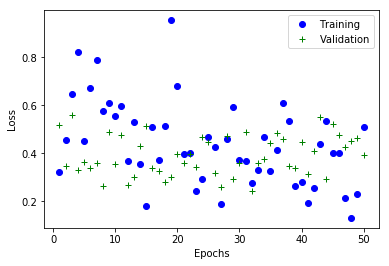

In [56]:
history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
fig,ax = plt.subplots()
# "bo" is for "blue dot"
ax.plot(epochs, loss_values, 'bo',label="Training")
# g+ is for "green crosses"
ax.plot(epochs, val_loss_values, 'g+',label="Validation")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(loc="best")
plt.show()

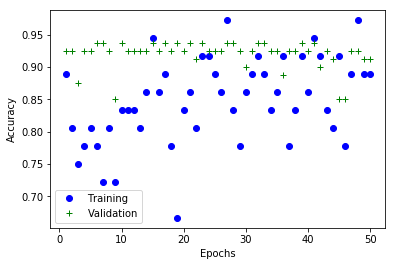

In [57]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)
# "bo" is for "blue dot"
fig, ax = plt.subplots()
ax.plot(epochs, acc_values, 'bo', label="Training")
# b+ is for "green crosses"
ax.plot(epochs, val_acc_values, 'g+', label="Validation")
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(loc="best")
plt.show()

In [58]:
ls

face_detection.py               __pycache__/
face recognition.ipynb          Training.ipynb
ImageAugmentationExample.ipynb  try_run_people_model_2.h5
img/                            try_run_people_model_2.pickle
img_Train_Test/                 try_run_people_model_3.h5
lfw_people_model_2.h5           try_run_people_model_3.pickle
lfw_people_model_2.pickle       try_run_people_model.h5
Predict.ipynb                   try_run_people_model.pickle
predict_label.py


In [26]:
from PIL import Image

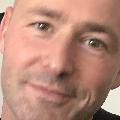

In [27]:
Image.open("img_Train_Test/Train/Djork-Arne_Clevert/853e2a0b-e1a3-45b8-a171-71a8d7fc00f7.jpg")